# Imports

In [60]:
import numpy as np
import pandas as pd
import os
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

from os.path import join as pjoin

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Data

In [61]:
# old calib model predictions from old data
mdf = pd.read_csv('corrected_wavelen_and_predictions.csv',
                 index_col=0)

In [4]:
# new calib model predictions 
path = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/\
calibration/community_calibration/predicted_fractions"""

# use a680_a720 @ 560
mdf = pd.read_csv(pjoin(path,'a680_a720_pred_fractions.csv'), index_col=0)

# Helper Functions 

In [66]:
def get_series(tdf, column='440'):
    """Returns a specific column as a Pandas Series"""
    
    return tdf[column]


def plot_relationship(tdf, column='440'):

    """Given a wavelength of interest this function displays a
    plot of the sum of the predicted values vs the values at
    that wavelength"""
    
    s1 = get_series(tdf, column)
    sm = get_series(tdf, 'B_p'+column) + get_series(tdf, 'C_p'+column)
    
    sns.regplot(x=s1, y=sm)
    plt.show()
    plt.close()
    
    

def get_96position(tdf, column='440'):
    """Returns the values of wanted column (lamda) as a DataFrame
    resembling its 96well plate layout. Facilitates comparison"""
    ninsix = pd.DataFrame()
    for l in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        c = tdf[tdf.index.str.contains(l)][column].values
        ninsix[l] = c
    ninsix = ninsix.transpose()
    ninsix.columns = ninsix.columns+1

    return ninsix.round(4)


def set_B_and_C(tdf, column):
    """This helper function sets the concentraiton values B and
    C on the dataframe for regressiong purposes and so that the 
    plotting function can plot the right values on the x-axis"""
    
    df = tdf.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    for row in rows:
        #print(row)
        value = df.loc[(df['row']==row) & (df['col']==12), column].iloc[0]
        df.loc[df['row']==row, 'B'] = value

    for col in cols:
        value = df.loc[(df['row']=='H') & (df['col']==col), column].iloc[0]
        df.loc[df['col']==col, 'C'] = value
    
    return df


def plot_pred_vs_known(mdf, column='440', ml_model=False):
    
    """This function takes in the previously calculated prediction values and
    outputs the the predicted vs known values for [chlamy] and [bacter], 
    column refers to the variable wavelength used to construct the regression
    that gave rise to the predicted values"""
    
    df = mdf.copy()

    df = set_B_and_C(df, column)
    
    # figsize
    fs = (8, 10)
    # alpha value for plot markers (see-throughness)
    a = 0.65
    # bacter figure
    fig0 = plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig0.add_subplot(gs[r,c]))

    
    # get predicted values from column named
    if ml_model:
        Bp = 'B_pML_'+column
    else:
        Bp = 'B_p'+column
        
    if ml_model:
        Cp = 'C_pML_'+column
    else:
        Cp = 'C_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Bp].max(), df['B'].max(), df[Cp].max(), df['C'].max())
    smx = smx+.1*smx
    
    sns.scatterplot(x='B', y=Bp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8),
                    edgecolor='black', alpha=a, ax=axes[0])
    
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [B]')
    axes[0].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[0].set_xlabel('$[B]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.01, right=smx) 
    axes[0].set_ylim(bottom=-0.01, top=smx)


    sns.scatterplot(x='B', y=Bp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12),
                    edgecolor='black', alpha=a, ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                   loc=2, prop={'size':9})
    axes[1].set_title('Predicted vs. Actual [B]')
    axes[1].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[1].set_xlabel('$[B]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.01, right=smx)
    axes[1].set_ylim(bottom=-0.01, top=smx)

    if ml_model:
        fig0.suptitle("[Bacteria] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig0.suptitle("[Bacteria] Predictions Using Simple Linear Regression Models @"+column, y=.95)
        
    fig0.subplots_adjust(hspace=.3)
    
    #plt.show()
    #plt.close()



    # CHLAMY
    fig1=plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig1.add_subplot(gs[r,c]))

    # get predicted values from column named
#     if ml_model:
#         Cp = 'C_pML_'+column
#     else:
#         Cp = 'C_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Cp].max(), df['C'].max(), df[Bp].max(), df['B'].max())
    smx = smx+.1*smx
    
    
    
    sns.scatterplot(x='C', y=Cp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8),
                    edgecolor='black', alpha=a,ax=axes[0])


    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [C]')
    axes[0].set_ylabel('$\hat{[C]_{pred}}$')
    axes[0].set_xlabel('$[C]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.01, right=smx)
    axes[0].set_ylim(bottom=-0.01, top=smx)


    sns.scatterplot(x='C', y=Cp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12),
                    edgecolor='black', alpha=a, ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                  prop={'size':9}, loc=2)
    axes[1].set_title('Predicted vs. Actual [C]')
    axes[1].set_ylabel('$\hat{[C]_{pred}}$')
    axes[1].set_xlabel('$[C]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.01, right=smx)
    axes[1].set_ylim(bottom=-0.01, top=smx)
    
    if ml_model:
        fig1.suptitle("[Chlamy] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig1.suptitle("[Chlamy] Predictions Using Simple Linear Regression Models @"+column, y=.95)
    
    fig1.subplots_adjust(hspace=.3)

    plt.show()
    plt.close()
    

# Analysis
    The aim here is to determine how to best represent the predicted signals as ratios but also to view the predicted values as they would appear on the 9well layout

## @ 560

In [67]:
mdf.head()
tdf = mdf.copy()
tdf = set_B_and_C(tdf, '560')

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,B_pML_780,C_pML_780,B_pML_785,C_pML_785,B_pML_790,C_pML_790,B_pML_795,C_pML_795,B_pML_800,C_pML_800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666.0,0.7210,0.4146,0.8399,0.8359,0.8349,...,0.211322,0.205691,0.210304,0.204017,0.209473,0.202604,0.208496,0.201029,0.207587,0.199716
B1,B,1,0.175,0.25,4832.0,0.7822,0.4155,0.8916,0.8890,0.8907,...,0.171481,0.242862,0.170650,0.240894,0.169978,0.239228,0.169178,0.237381,0.168445,0.235829
C1,C,1,0.150,0.25,4638.0,0.6925,0.3829,0.7923,0.7897,0.7912,...,0.173228,0.207293,0.172388,0.205607,0.171706,0.204181,0.170897,0.202592,0.170155,0.201266
D1,D,1,0.125,0.25,4775.0,0.6981,0.3593,0.7690,0.7657,0.7669,...,0.113628,0.229376,0.113065,0.227514,0.112620,0.225936,0.112074,0.224182,0.111594,0.222714
E1,E,1,0.100,0.25,4936.0,0.6788,0.3414,0.7440,0.7413,0.7438,...,0.102288,0.225634,0.101778,0.223802,0.101378,0.222249,0.100881,0.220521,0.100451,0.219076


In [68]:
# PREDICTED 560 SIGNAL Fractions
pB = get_96position(tdf, 'B_p560')
pC = get_96position(tdf, 'C_p560')
f60 = get_96position(tdf, '560')

cm = [sns.light_palette("brown", as_cmap=True),
      sns.light_palette("green", as_cmap=True), 
      sns.light_palette("purple", as_cmap=True)]

'predicted fractions at wells'
pB.style.background_gradient(cmap=cm[0], axis=None)
pC.style.background_gradient(cmap=cm[1], axis=None)


'predicted fractions at wells'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2639,0.258,0.2849,0.2696,0.2409,0.2613,0.2389,0.2577,0.2653,0.267,0.2609,0.2642
B,0.2152,0.2572,0.2099,0.2814,0.2294,0.2359,0.235,0.229,0.2238,0.242,0.2291,0.2301
C,0.2163,0.1983,0.1944,0.1901,0.1803,0.181,0.1925,0.179,0.2028,0.1826,0.1733,0.1759
D,0.1425,0.1443,0.1493,0.1654,0.1426,0.138,0.1369,0.1331,0.1436,0.1336,0.1482,0.1451
E,0.1282,0.1181,0.1166,0.1466,0.1254,0.1315,0.1182,0.1085,0.0867,0.1041,0.1022,0.1123
F,0.0792,0.0721,0.0647,0.065,0.0324,0.0086,0.0328,0.0163,0.0507,0.0474,0.0689,0.0473
G,0.0544,0.0367,0.014,0.0034,-0.0254,-0.0262,-0.02,0.0051,0.0196,0.034,0.0255,0.0176
H,0.018,0.0009,0.0005,0.0071,0.0351,0.019,0.0077,0.0142,0.028,0.0227,0.0029,0


,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2563,0.2273,0.1928,0.1723,0.197,0.1402,0.1502,0.0884,0.0675,0.0394,0.0146,0.0017
B,0.3132,0.2158,0.4169,0.1663,0.1499,0.1455,0.1071,0.0885,0.0631,0.0308,0.0088,0.0023
C,0.2646,0.2435,0.2053,0.195,0.1525,0.1414,0.1178,0.0998,0.0681,0.0372,0.0119,0.0036
D,0.3041,0.2622,0.2548,0.2202,0.1622,0.1999,0.1279,0.124,0.0662,0.0386,0.0076,0.0012
E,0.3008,0.277,0.2537,0.1778,0.1782,0.1539,0.1343,0.1012,0.0832,0.0367,0.0113,0.0058
F,0.305,0.3165,0.3077,0.2544,0.2528,0.2177,0.1288,0.1276,0.0696,0.0366,0.007,0.0031
G,0.3137,0.3376,0.2664,0.2763,0.2056,0.1776,0.1575,0.1087,0.068,0.024,0.0052,0.0039
H,0.331,0.3207,0.2426,0.2259,0.1728,0.1506,0.1224,0.0905,0.0472,0.0189,0.0042,-0


In [69]:
# 'KNOWN Concentrations as Measured by 560 at row H and col 12'
B = get_96position(tdf, 'B')
C = get_96position(tdf, 'C')

# How should these sums behave
'Sum of B&C-only measured wells  @560'
# Note that this is not the same as A560_total = kB560*[B] + kC560*[C]
# This is a just a helpful approximation
msm = B+C
msm.style.background_gradient(cmap=cm[0], axis=None)

'Empirical @ 560'
f60.style.background_gradient(cmap=cm[2], axis=None)

'Predicted pB & pC sums'
sm = pB + pC
sm.style.background_gradient(cmap=cm[0], axis=None )



# since absorbance signals at any wavelengths are additive, we should see an increase
# in the signal going from bottom-to-top... IFF the concentration of bacteria is too
# small and is canceled out by the chlamy signal, then we should see values close
# to the 'Known C concentration from bottom-to-top at any respective cell....


# That is not the case and there is a clear contribution of bacteria to the signals 
# Could there be an issue with the coefficients during the regression, NOTE that
# the coefficients for @ kB72x and kC72x are VERY similar.... this might mean there
# math issue

'Sum of B&C-only measured wells  @560'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.6165,0.5879,0.5078,0.5027,0.4762,0.4406,0.4005,0.3745,0.3416,0.3087,0.2754,0.2655
B,0.5857,0.5571,0.477,0.4719,0.4454,0.4098,0.3697,0.3437,0.3108,0.2779,0.2446,0.2347
C,0.5337,0.5051,0.425,0.4199,0.3934,0.3578,0.3177,0.2917,0.2588,0.2259,0.1926,0.1827
D,0.4993,0.4707,0.3906,0.3855,0.359,0.3234,0.2833,0.2573,0.2244,0.1915,0.1582,0.1483
E,0.4711,0.4425,0.3624,0.3573,0.3308,0.2952,0.2551,0.2291,0.1962,0.1633,0.13,0.1201
F,0.403,0.3744,0.2943,0.2892,0.2627,0.2271,0.187,0.161,0.1281,0.0952,0.0619,0.052
G,0.3751,0.3465,0.2664,0.2613,0.2348,0.1992,0.1591,0.1331,0.1002,0.0673,0.034,0.0241
H,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0


'Empirical @ 560'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.5276,0.4919,0.4823,0.4442,0.4404,0.4065,0.3979,0.349,0.3337,0.3104,0.279,0.2655
B,0.5417,0.4805,0.6373,0.4551,0.3846,0.385,0.3496,0.3199,0.2892,0.2736,0.2383,0.2347
C,0.4922,0.4518,0.4099,0.3938,0.3415,0.3273,0.3148,0.2807,0.2734,0.2223,0.1865,0.1827
D,0.4563,0.4166,0.4134,0.3938,0.3122,0.3434,0.2685,0.2585,0.2116,0.1748,0.1574,0.1483
E,0.4388,0.4035,0.3781,0.3321,0.3078,0.2919,0.2547,0.215,0.1731,0.1438,0.1157,0.1201
F,0.3897,0.3956,0.3772,0.322,0.2877,0.2315,0.1669,0.149,0.1263,0.0873,0.0774,0.052
G,0.3687,0.3772,0.2814,0.2804,0.1831,0.1556,0.1389,0.1177,0.0917,0.0633,0.0337,0.0241
H,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0


'Predicted pB & pC sums'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.5202,0.4853,0.4777,0.4419,0.4379,0.4015,0.3891,0.3461,0.3328,0.3064,0.2755,0.2659
B,0.5284,0.473,0.6268,0.4477,0.3793,0.3814,0.3421,0.3175,0.2869,0.2728,0.2379,0.2324
C,0.4809,0.4418,0.3997,0.3851,0.3328,0.3224,0.3103,0.2788,0.2709,0.2198,0.1852,0.1795
D,0.4466,0.4065,0.4041,0.3856,0.3048,0.3379,0.2648,0.2571,0.2098,0.1722,0.1558,0.1463
E,0.429,0.3951,0.3703,0.3244,0.3036,0.2854,0.2525,0.2097,0.1699,0.1408,0.1135,0.1181
F,0.3842,0.3886,0.3724,0.3194,0.2852,0.2263,0.1616,0.1439,0.1203,0.084,0.0759,0.0504
G,0.3681,0.3743,0.2804,0.2797,0.1802,0.1514,0.1375,0.1138,0.0876,0.058,0.0307,0.0215
H,0.349,0.3216,0.2431,0.233,0.2079,0.1696,0.1301,0.1047,0.0752,0.0416,0.0071,0


In [70]:
# "known concentrations.... what we expect the concentrations to be"

"'actual C'"
C.style.background_gradient(cmap=cm[1], axis=None)

"'actual' B"
B.style.background_gradient(cmap=cm[0], axis=None)

# these should remain fairly static
'predicted C'
pC.style.background_gradient(cmap=cm[1], axis=None )

'pred B'
pB.style.background_gradient(cmap=cm[0], axis=None)

(pC - C).style.background_gradient(cmap=cm[1], axis=None)
#np.sqrt(np.power((pC - C),2)).style.background_gradient(cmap=cm[1], axis=None)

"'actual C'"

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
B,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
C,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
D,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
E,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
F,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
G,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
H,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0


"'actual' B"

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655
B,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347
C,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827
D,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483
E,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201
F,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052
G,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241
H,0,0,0,0,0,0,0,0,0,0,0,0


'predicted C'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2563,0.2273,0.1928,0.1723,0.197,0.1402,0.1502,0.0884,0.0675,0.0394,0.0146,0.0017
B,0.3132,0.2158,0.4169,0.1663,0.1499,0.1455,0.1071,0.0885,0.0631,0.0308,0.0088,0.0023
C,0.2646,0.2435,0.2053,0.195,0.1525,0.1414,0.1178,0.0998,0.0681,0.0372,0.0119,0.0036
D,0.3041,0.2622,0.2548,0.2202,0.1622,0.1999,0.1279,0.124,0.0662,0.0386,0.0076,0.0012
E,0.3008,0.277,0.2537,0.1778,0.1782,0.1539,0.1343,0.1012,0.0832,0.0367,0.0113,0.0058
F,0.305,0.3165,0.3077,0.2544,0.2528,0.2177,0.1288,0.1276,0.0696,0.0366,0.007,0.0031
G,0.3137,0.3376,0.2664,0.2763,0.2056,0.1776,0.1575,0.1087,0.068,0.024,0.0052,0.0039
H,0.331,0.3207,0.2426,0.2259,0.1728,0.1506,0.1224,0.0905,0.0472,0.0189,0.0042,-0


'pred B'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2639,0.258,0.2849,0.2696,0.2409,0.2613,0.2389,0.2577,0.2653,0.267,0.2609,0.2642
B,0.2152,0.2572,0.2099,0.2814,0.2294,0.2359,0.235,0.229,0.2238,0.242,0.2291,0.2301
C,0.2163,0.1983,0.1944,0.1901,0.1803,0.181,0.1925,0.179,0.2028,0.1826,0.1733,0.1759
D,0.1425,0.1443,0.1493,0.1654,0.1426,0.138,0.1369,0.1331,0.1436,0.1336,0.1482,0.1451
E,0.1282,0.1181,0.1166,0.1466,0.1254,0.1315,0.1182,0.1085,0.0867,0.1041,0.1022,0.1123
F,0.0792,0.0721,0.0647,0.065,0.0324,0.0086,0.0328,0.0163,0.0507,0.0474,0.0689,0.0473
G,0.0544,0.0367,0.014,0.0034,-0.0254,-0.0262,-0.02,0.0051,0.0196,0.034,0.0255,0.0176
H,0.018,0.0009,0.0005,0.0071,0.0351,0.019,0.0077,0.0142,0.028,0.0227,0.0029,0


,1,2,3,4,5,6,7,8,9,10,11,12
A,-0.0947,-0.0951,-0.0495,-0.0649,-0.0137,-0.0349,0.0152,-0.0206,-0.0086,-0.0038,0.0047,0.0017
B,-0.0378,-0.1066,0.1746,-0.0709,-0.0608,-0.0296,-0.0279,-0.0205,-0.013,-0.0124,-0.0011,0.0023
C,-0.0864,-0.0789,-0.037,-0.0422,-0.0582,-0.0337,-0.0172,-0.0092,-0.008,-0.006,0.002,0.0036
D,-0.0469,-0.0602,0.0125,-0.017,-0.0485,0.0248,-0.0071,0.015,-0.0099,-0.0046,-0.0023,0.0012
E,-0.0502,-0.0454,0.0114,-0.0594,-0.0325,-0.0212,-0.0007,-0.0078,0.0071,-0.0065,0.0014,0.0058
F,-0.046,-0.0059,0.0654,0.0172,0.0421,0.0426,-0.0062,0.0186,-0.0065,-0.0066,-0.0029,0.0031
G,-0.0373,0.0152,0.0241,0.0391,-0.0051,0.0025,0.0225,-0.0003,-0.0081,-0.0192,-0.0047,0.0039
H,-0.02,-0.0017,0.0003,-0.0113,-0.0379,-0.0245,-0.0126,-0.0185,-0.0289,-0.0243,-0.0057,-0


In [71]:
"'actual' B"
B.style.background_gradient(cmap=cm[0], axis=None)


'pred B'
pB.style.background_gradient(cmap=cm[0], axis=None)

"'actual' B"

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655
B,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347
C,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827
D,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483
E,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201
F,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052
G,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241
H,0,0,0,0,0,0,0,0,0,0,0,0


'pred B'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2639,0.258,0.2849,0.2696,0.2409,0.2613,0.2389,0.2577,0.2653,0.267,0.2609,0.2642
B,0.2152,0.2572,0.2099,0.2814,0.2294,0.2359,0.235,0.229,0.2238,0.242,0.2291,0.2301
C,0.2163,0.1983,0.1944,0.1901,0.1803,0.181,0.1925,0.179,0.2028,0.1826,0.1733,0.1759
D,0.1425,0.1443,0.1493,0.1654,0.1426,0.138,0.1369,0.1331,0.1436,0.1336,0.1482,0.1451
E,0.1282,0.1181,0.1166,0.1466,0.1254,0.1315,0.1182,0.1085,0.0867,0.1041,0.1022,0.1123
F,0.0792,0.0721,0.0647,0.065,0.0324,0.0086,0.0328,0.0163,0.0507,0.0474,0.0689,0.0473
G,0.0544,0.0367,0.014,0.0034,-0.0254,-0.0262,-0.02,0.0051,0.0196,0.034,0.0255,0.0176
H,0.018,0.0009,0.0005,0.0071,0.0351,0.019,0.0077,0.0142,0.028,0.0227,0.0029,0


In [72]:
# So clearly the contribution to the signal by bacteria is being tracked, however
# as we can note above as the concentration of Chlamy increases the contribution
# of bacteria to the signal is sub-estimated 

In [73]:
#(-pC).style.background_gradient(cmap=cm[2], axis=None)

In [74]:
pB

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2639,0.2580,0.2849,0.2696,0.2409,0.2613,0.2389,0.2577,0.2653,0.2670,0.2609,0.2642
B,0.2152,0.2572,0.2099,0.2814,0.2294,0.2359,0.2350,0.2290,0.2238,0.2420,0.2291,0.2301
C,0.2163,0.1983,0.1944,0.1901,0.1803,0.1810,0.1925,0.1790,0.2028,0.1826,0.1733,0.1759
D,0.1425,0.1443,0.1493,0.1654,0.1426,0.1380,0.1369,0.1331,0.1436,0.1336,0.1482,0.1451
E,0.1282,0.1181,0.1166,0.1466,0.1254,0.1315,0.1182,0.1085,0.0867,0.1041,0.1022,0.1123
F,0.0792,0.0721,0.0647,0.0650,0.0324,0.0086,0.0328,0.0163,0.0507,0.0474,0.0689,0.0473
G,0.0544,0.0367,0.0140,0.0034,-0.0254,-0.0262,-0.0200,0.0051,0.0196,0.0340,0.0255,0.0176
H,0.0180,0.0009,0.0005,0.0071,0.0351,0.0190,0.0077,0.0142,0.0280,0.0227,0.0029,0.0000


Text(0.5, 0, 'B')

Text(0, 0.5, 'pC')

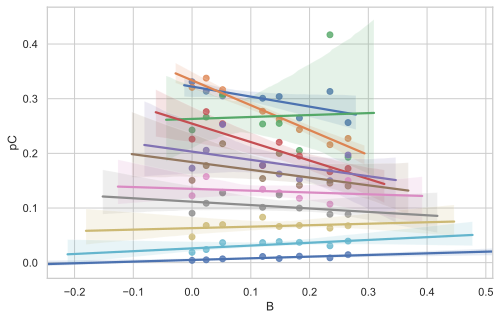

In [75]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=(8,5))
coefs = []
for i in range(1,12):
    
    regr = LinearRegression()
    k = regr.fit(y=pC[i].values.reshape(-1,1), X=B[12].values.reshape(-1,1))
    
    coefs.append(k.coef_[0])
    
    sns.regplot(y=pC[i], x=B[12])
    
ax.set_xlabel('B')
ax.set_ylabel('pC')

In [76]:
#cK = np.array(coefs).mean()
cK = np.array(coefs)

In [77]:
cK[-1]

array([0.03031734])

In [78]:
" ' corrected pC' "
cpC = pC - cK[-1][0]*pC

#pC - cK*C


'pC'
pC

'C'
C


# Its not a correction factor that you can multiply to C, its a correction facctor
# that depends on B, much like you've done on the other page...

" ' corrected pC' "

'pC'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2563,0.2273,0.1928,0.1723,0.1970,0.1402,0.1502,0.0884,0.0675,0.0394,0.0146,0.0017
B,0.3132,0.2158,0.4169,0.1663,0.1499,0.1455,0.1071,0.0885,0.0631,0.0308,0.0088,0.0023
C,0.2646,0.2435,0.2053,0.1950,0.1525,0.1414,0.1178,0.0998,0.0681,0.0372,0.0119,0.0036
D,0.3041,0.2622,0.2548,0.2202,0.1622,0.1999,0.1279,0.1240,0.0662,0.0386,0.0076,0.0012
E,0.3008,0.2770,0.2537,0.1778,0.1782,0.1539,0.1343,0.1012,0.0832,0.0367,0.0113,0.0058
F,0.3050,0.3165,0.3077,0.2544,0.2528,0.2177,0.1288,0.1276,0.0696,0.0366,0.0070,0.0031
G,0.3137,0.3376,0.2664,0.2763,0.2056,0.1776,0.1575,0.1087,0.0680,0.0240,0.0052,0.0039
H,0.3310,0.3207,0.2426,0.2259,0.1728,0.1506,0.1224,0.0905,0.0472,0.0189,0.0042,-0.0000


'C'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
B,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
C,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
D,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
E,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
F,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
G,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
H,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0


In [79]:
'B'
B
'pB'
pB
'C'
C
'pC'
pC

'B'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655
B,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347
C,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827
D,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483
E,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201
F,0.0520,0.0520,0.0520,0.0520,0.0520,0.0520,0.0520,0.0520,0.0520,0.0520,0.0520,0.0520
G,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241
H,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


'pB'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2639,0.2580,0.2849,0.2696,0.2409,0.2613,0.2389,0.2577,0.2653,0.2670,0.2609,0.2642
B,0.2152,0.2572,0.2099,0.2814,0.2294,0.2359,0.2350,0.2290,0.2238,0.2420,0.2291,0.2301
C,0.2163,0.1983,0.1944,0.1901,0.1803,0.1810,0.1925,0.1790,0.2028,0.1826,0.1733,0.1759
D,0.1425,0.1443,0.1493,0.1654,0.1426,0.1380,0.1369,0.1331,0.1436,0.1336,0.1482,0.1451
E,0.1282,0.1181,0.1166,0.1466,0.1254,0.1315,0.1182,0.1085,0.0867,0.1041,0.1022,0.1123
F,0.0792,0.0721,0.0647,0.0650,0.0324,0.0086,0.0328,0.0163,0.0507,0.0474,0.0689,0.0473
G,0.0544,0.0367,0.0140,0.0034,-0.0254,-0.0262,-0.0200,0.0051,0.0196,0.0340,0.0255,0.0176
H,0.0180,0.0009,0.0005,0.0071,0.0351,0.0190,0.0077,0.0142,0.0280,0.0227,0.0029,0.0000


'C'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
B,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
C,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
D,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
E,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
F,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
G,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0
H,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0.0


'pC'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2563,0.2273,0.1928,0.1723,0.1970,0.1402,0.1502,0.0884,0.0675,0.0394,0.0146,0.0017
B,0.3132,0.2158,0.4169,0.1663,0.1499,0.1455,0.1071,0.0885,0.0631,0.0308,0.0088,0.0023
C,0.2646,0.2435,0.2053,0.1950,0.1525,0.1414,0.1178,0.0998,0.0681,0.0372,0.0119,0.0036
D,0.3041,0.2622,0.2548,0.2202,0.1622,0.1999,0.1279,0.1240,0.0662,0.0386,0.0076,0.0012
E,0.3008,0.2770,0.2537,0.1778,0.1782,0.1539,0.1343,0.1012,0.0832,0.0367,0.0113,0.0058
F,0.3050,0.3165,0.3077,0.2544,0.2528,0.2177,0.1288,0.1276,0.0696,0.0366,0.0070,0.0031
G,0.3137,0.3376,0.2664,0.2763,0.2056,0.1776,0.1575,0.1087,0.0680,0.0240,0.0052,0.0039
H,0.3310,0.3207,0.2426,0.2259,0.1728,0.1506,0.1224,0.0905,0.0472,0.0189,0.0042,-0.0000


(-0.4, 0.8)

(-0.4, 0.8)

Text(0.5, 0, 'C')

Text(0, 0.5, 'pB')

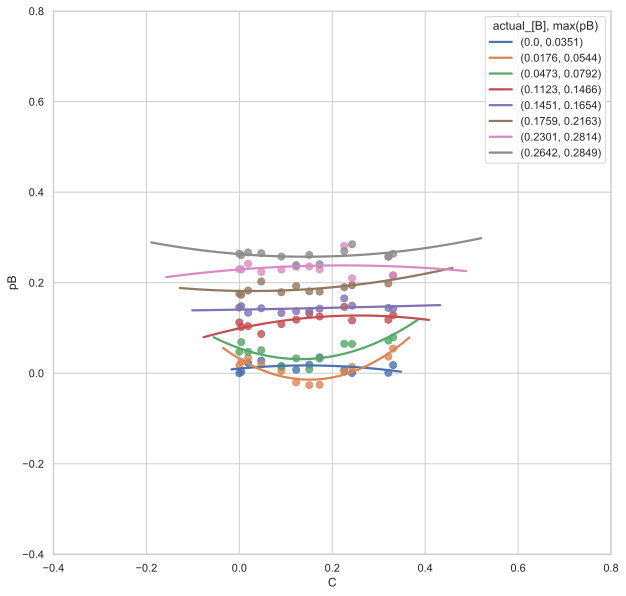

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
#ax2 = plt.twinx()
box = ['A']
box = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'][::-1]
#box = ['C', 'D']
#box = ['E', 'F']
#box = ['D']
mxvals = []
for i in box:#['A', 'B', 'C', 'D', 'E', 'F', 'G']:0
    mxvals.append(max(pB.loc[i].values[::-1]))
    #sns.scatterplot(y=pB.loc[i].values[::-1], x=pC.loc['H'].values[::-1], ax=ax)
    sns.regplot(x=pC.loc['H'].values[::-1], y=pB.loc[i].values[::-1],
                scatter_kws={"s": 50}, order=2, ci=None, truncate=False)

ax.set_ylim(-0.4, .8)
ax.set_xlim(-0.4, .8)
ax.set_xlabel('C')
ax.set_ylabel('pB')

ax.legend([i for i in zip(pB[12].values[::-1], mxvals)], 
          title='actual_[B], max(pB)')
#ax.legend(pB[12].values)



# C is measured
# What is this telling you

In [81]:
C.loc['H'].values[::-1]


array([0.    , 0.0099, 0.0432, 0.0761, 0.109 , 0.135 , 0.1751, 0.2107,
       0.2372, 0.2423, 0.3224, 0.351 ])

In [82]:
# in the H:H plot (gray dots) ... the model is attributing bacterial
# signal where there shouldn't be any

In [83]:
# Polyfit a model

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq


# Data to be fitted

In [84]:
X = pC.loc['H'].values[::-1]#.reshape(-1,1)
# y = pB.loc['H'].values[::-1]#.reshape(-1,1)
Y = pB.loc['D'].values[::-1]

#X = np.array([1,2,3,4,5,6])
#Y=np.array([9.1,18.3,32,47,69.5,94.8])


# Standard Form of Quadratic Function
def func(params, x):
    a, b, c = params
    return a * x * x + b * x + c


# Error function, that is, the difference between the value obtained by fitting curve and the actual value
def error(params, x, y):
    return func(params, x) - y


# Solving parameters
def slovePara():
    p0 = [10, 10, 10]

    Para = leastsq(error, p0, args=(X, Y))
    return Para


# Output the final result
def solution(X,Y):
    Para = slovePara()
    a, b, c = Para[0]
    print("a=",a," b=",b," c=",c)
    print("cost:" + str(Para[1]))
    print("The curve of solution is: ")
    print("y="+str(round(a,2))+"x*x+"+str(round(b,2))+"x+"+str(c))

# plt.figure(figsize=(8,6))
# plt.scatter(X, Y, color="green", label="sample data", linewidth=2)

# # Drawing Fitted Lines
# #X = np. linspace (0, 12, 100) # draw 100 continuous points directly from 0 to 15
# #Y = a * x * x + b * x + C # # function
# #plt.plot(x,y,color="red",label="solution line",linewidth=2)
# #Plt. legend ()# Draw Legend
# plt.show()


solution(X,Y)

a= 0.012494390534317737  b= 0.017682424413552937  c= 0.14058838435259505
cost:1
The curve of solution is: 
y=0.01x*x+0.02x+0.14058838435259505


In [100]:
def h_k(a2a1a0):
    a, b, c = a2a1a0
    
    h = -(b / 2*a)    
    k = a*(h**2) + b*h + 0
    
    #print(2*h, k)
    
    return h, k

In [101]:
x = pC.loc['H'].values[::-1]#.reshape(-1,1)
y = pB.loc['H'].values[::-1]#.reshape(-1,1)
y = pB.loc['D'].values[::-1]
fig, ax = plt.subplots(figsize=(8,8))
#y = pB.loc['A'].values[::-1]
ass = []
mxb = []
#mnb = []
box = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'][::-1]
hs = []
for b in box:
    b
    mxb.append(min(pB.loc[b].values[::-1]))
    
    y = pB.loc[b].values[::-1]
    pfit = np.polyfit(x, y, deg=2)# rcond=None, full=True, w=None, cov=False)
    ass.append(pfit[0])
    pfit[2] = 0
    pfit
    ptor = np.poly1d(pfit)
# pfit
# 'pB'
# pB

# 'pC'
# pC
    xp = np.linspace(-1, 1.5, 100)

    plt.plot(x, y, '.', xp, ptor(xp), '-', xp, corr_func(xp), '-.')
    ps=ptor(xp).copy()
    k=max(ps)
    h=xp[np.argmax(ps)]
    h
    hs.append(h)
    ph,pk = h_k(pfit)
    print('h,k:',h,k)
    plt.plot(h,k, 'ro', ph,pk, 'k.')
    plt.ylim(-0.1,0.1)
    ax.set_xlabel('C')
    ax.set_ylabel('pB error')
#for 
#xp = # pC of (pC,pB) for which you want to perform the correction pB' = pB + ptor 

AttributeError: 'numpy.float64' object has no attribute 'loc'

In [88]:
# here were are modeling the apparent relationship that 'h' in f(h) = a(x - h)**2 + k=0 
pB[12]
B[12]

hs = np.array(hs)
hs[-1] = 0
hs
ba0= np.array(pB[12].values[::-1])

hfit = np.polyfit(ba0[:-1], hs[:-1], deg=1)
htor = np.poly1d(hfit)
htor
xp = np.linspace(-0.05, .6, 20)
plt.plot(ba0, hs, 'ro', xp, htor(xp))

A    0.2642
B    0.2301
C    0.1759
D    0.1451
E    0.1123
F    0.0473
G    0.0176
H    0.0000
Name: 12, dtype: float64

A    0.2655
B    0.2347
C    0.1827
D    0.1483
E    0.1201
F    0.0520
G    0.0241
H    0.0000
Name: 12, dtype: float64

IndexError: index -1 is out of bounds for axis 0 with size 0

In [348]:
print(hfit)

[-1.50729488  0.14397325  0.32429749]


In [89]:
np.median(ass[:-1])
np.median(ass)

ass
mxb
hs
np.mean(hs)
p_h = htor(pB)
average_a = np.mean(ass)

average_a
b = -2*average_a*p_h
corr_func = np.poly1d(np.array([average_a, b, 0 ]))

0.012494866876494672

0.1435453797188658

[-0.3340246175760163,
 2.0182970673161273,
 1.3733025358374824,
 -0.4288519407220817,
 0.012494866876494672,
 0.27459589256123695,
 -0.1782801279709662,
 0.2865468432180166]

[0.0, -0.0262, 0.0086, 0.0867, 0.1331, 0.1733, 0.2099, 0.2389]

array([], dtype=float64)

/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

0.3780100649425367

In [51]:
average_a

-0.5277617179874656

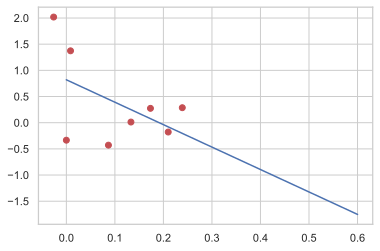

In [90]:
afit = np.polyfit(mxb, ass, deg=1)
ator = np.poly1d(afit)

xp = np.linspace(0, .6, 20)
plt.plot(mxb, ass, 'ro', xp, ator(xp))

In [91]:
hs = np.array(hs)
mxb = np.array(mxb)
hfit = np.polyfit(mxb, hs, deg=1)
htor = np.poly1d(hfit)


xp = np.linspace(-0.05, .6, 20)
plt.plot(mxb, hs, 'ro', xp, ator(xp))

TypeError: expected x and y to have same length

In [317]:
ass = np.array(ass)
mxb = np.array(mxb)

In [95]:
%config InteractiveShell.ast_node_interactivity='none'


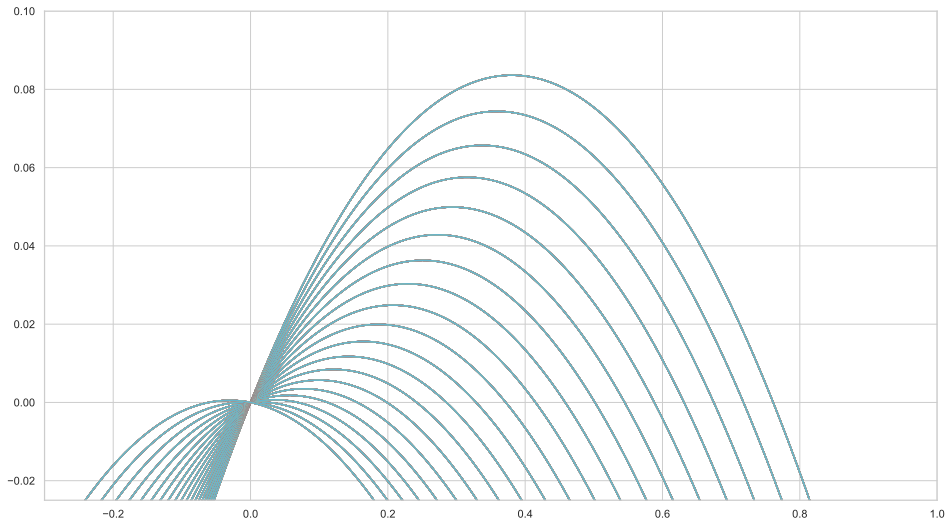

In [96]:
%config InteractiveShell.ast_node_interactivity='none'
fig, ax = plt.subplots(figsize=(16,9))
for pB in np.linspace(-.1, 1, 20):
    for pC in np.linspace(-1., 1, 20):

        h_fit = np.array([-0.37369705,  0.34323916])


        h_tor = np.poly1d(h_fit)
        p_h = h_tor(pB)
        #print('ph', p_h)
        # values obtained from separate regression

        a_ = -0.5773230891714184
        b_ = -2*p_h*a_

        c_tor = np.poly1d([a_, b_, 0])

        xp = np.linspace(-2, 2, 1000)
        plt.plot(xp, c_tor(xp))
        plt.ylim(-0.025, 0.1)
        plt.xlim(-0.3, 1)
%config InteractiveShell.ast_node_interactivity='all'
        

# Apply Correction Factor

In [97]:
def  corr_func(pB, pC):
    #irrigation scheduling.

    
    # values obtained from separate regression
    h_fit = np.array([-1.38020011,  0.10059416,  0.35124885) # deg2
    h_fit = np.array([-0.57601171,  0.37860475])
    h_fit = np.array([-0.37369705,  0.34323916])
    

    h_tor = np.poly1d(h_fit)
    p_h = h_tor(pB)
    print('ph', p_h)
    # values obtained from separate regression
    
    a_ = -0.5773230891714184
    b_ = -2*p_h*a_
    
    c_tor = np.poly1d([a_, b_, 0])
    
    xp = np.linspace(-2, 2, 2000)
    plt.plot(xp, c_tor(xp))
    plt.ylim(-0.025, 0.1)
    plt.xlim(-0.3, 1)
    
    print(c_tor)
    return c_tor(pC)
    
    

ph 0.2446080173475821
         2
-0.5773 x + 0.2824 x
ph 0.2628054345029448
         2
-0.5773 x + 0.3034 x
ph 0.26239223796700883
         2
-0.5773 x + 0.303 x
ph 0.28999470522987664
         2
-0.5773 x + 0.3348 x
ph 0.2953364545673203
         2
-0.5773 x + 0.341 x
ph 0.3136429789152756
         2
-0.5773 x + 0.3621 x
ph 0.32290510753973484
         2
-0.5773 x + 0.3728 x
ph 0.33650783777068566
         2
-0.5773 x + 0.3885 x
ph 0.2468242642651846
         2
-0.5773 x + 0.285 x
ph 0.2471079464797753
         2
-0.5773 x + 0.2853 x
ph 0.2691413904048404
         2
-0.5773 x + 0.3108 x
ph 0.2893275472158416
         2
-0.5773 x + 0.3341 x
ph 0.2991227436229082
         2
-0.5773 x + 0.3454 x
ph 0.31627936771429516
         2
-0.5773 x + 0.3652 x
ph 0.32951142075058243
         2
-0.5773 x + 0.3805 x
ph 0.34289495608218745
         2
-0.5773 x + 0.3959 x
ph 0.23677827804427912
         2
-0.5773 x + 0.2734 x
ph 0.26478839674053567
         2
-0.5773 x + 0.3057 x
ph 0.27058059705267556

,B_p560,C_p560,cf
well,,,
A1,0.263933,0.256317,0.034464
B1,0.215238,0.313244,0.038405
C1,0.216343,0.264566,0.039746
D1,0.142480,0.304109,0.048436
E1,0.128186,0.300824,0.050339
F1,0.079198,0.305042,0.056750
G1,0.054413,0.313707,0.060147
H1,0.018013,0.330962,0.065357
A2,0.258003,0.227324,0.034952


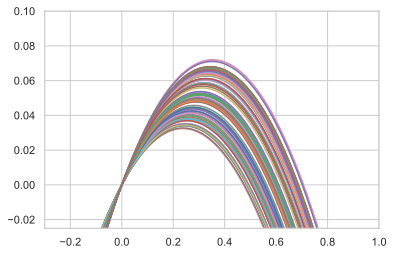

In [98]:
tdf = mdf.copy()

tdf['cf'] =  tdf.apply(lambda x: corr_func(x['B_p560'], x['C_p560']), axis=1)
#tdf['cf'] = corr_func(tdf['C_p560'])

tdf['Btmp_p560'] = tdf['B_p560'].copy()
tdf['Ctmp_p560'] = tdf['C_p560'].copy()

tdf[['B_p560', 'C_p560', 'cf']]

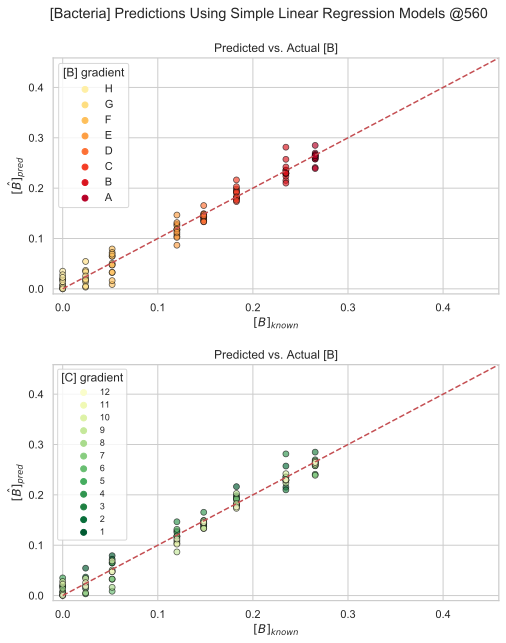

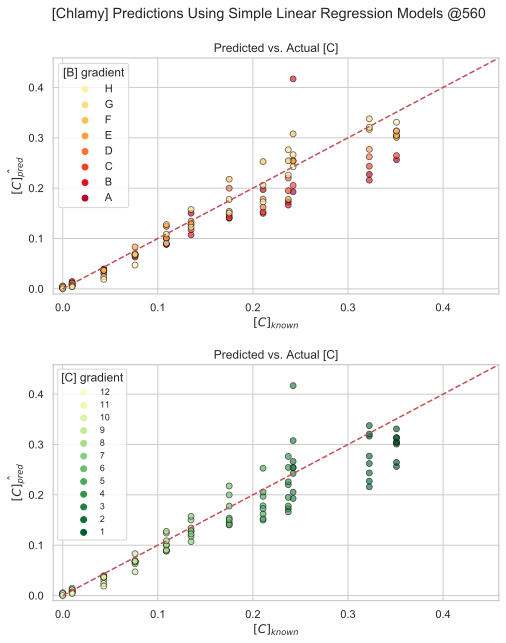

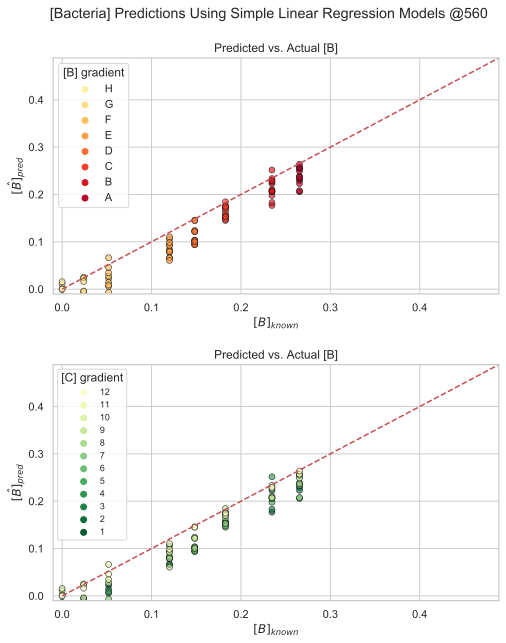

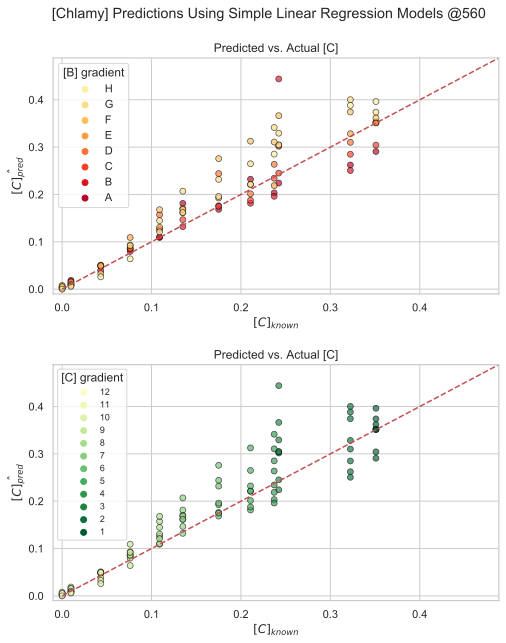

In [99]:
tdf['B_p560'] = tdf['Btmp_p560'] - tdf['cf']
tdf['C_p560'] = tdf['Ctmp_p560'] + tdf['cf']
plot_pred_vs_known(mdf, column='560', ml_model=False)
plot_pred_vs_known(tdf, column='560', ml_model=False)


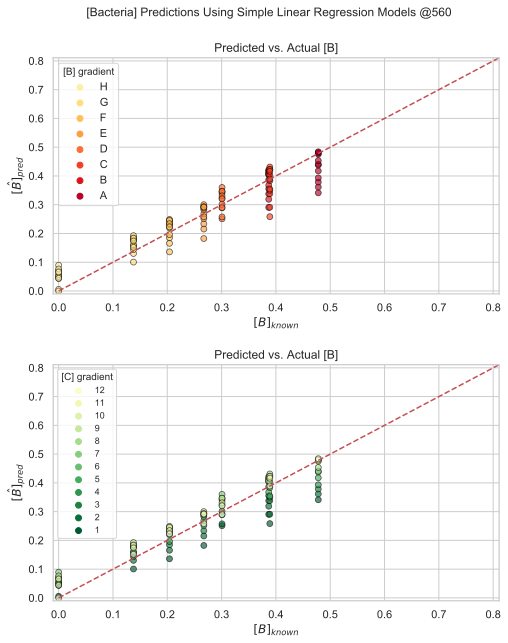

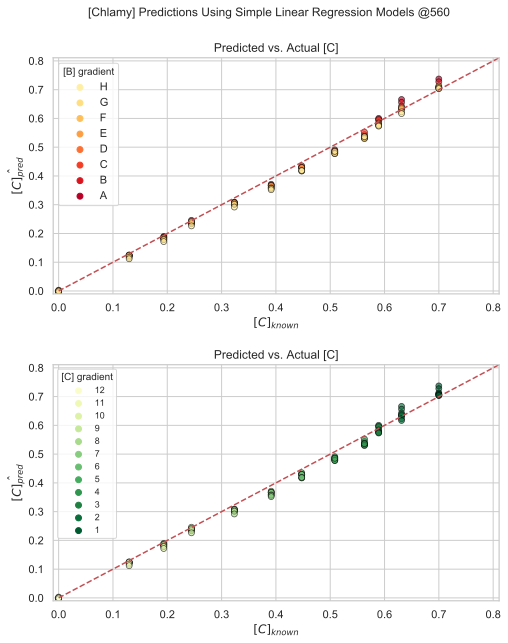

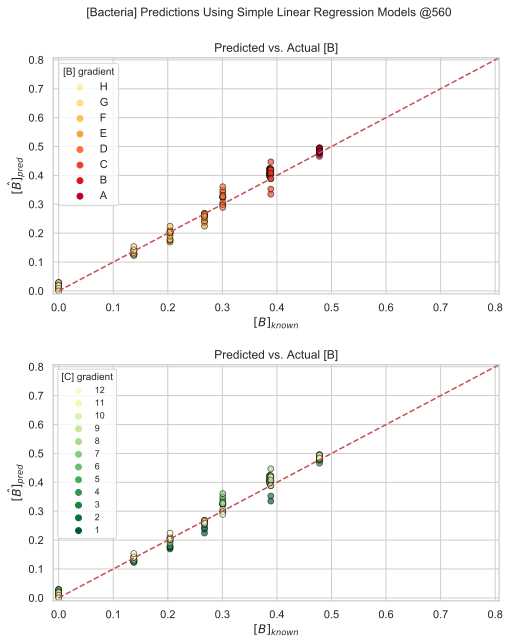

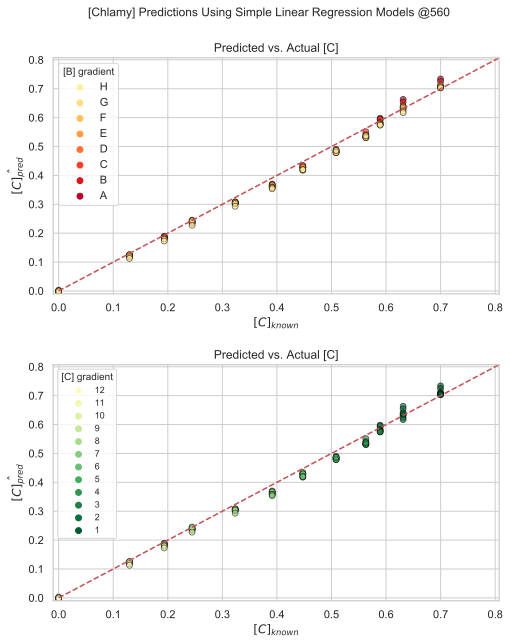

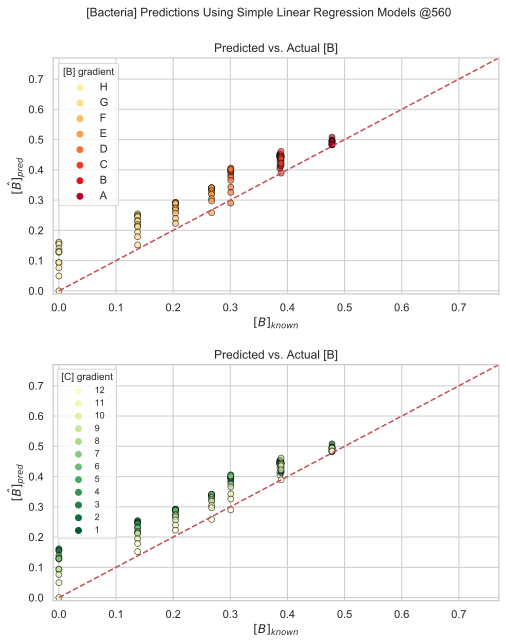

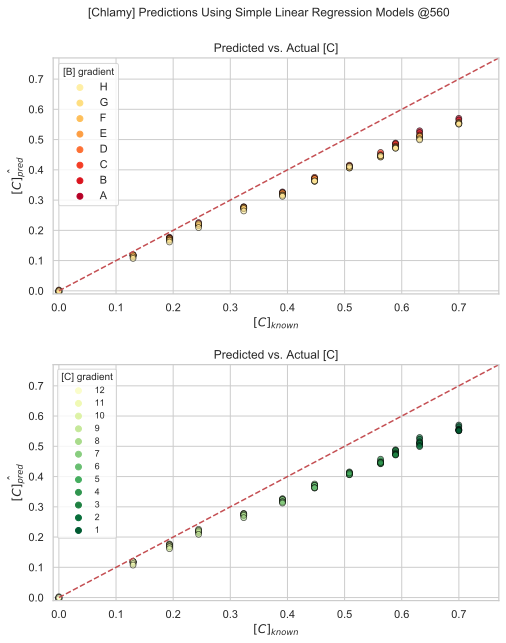

In [ ]:
pd.set_option('max_rows', 97)
#tdf[['C_p560', 'Btmp_p560','B_p560']]

In [ ]:
#for 
#xp = # pC of (pC,pB) for which you want to perform the correction pB' = pB + ptor 

In [ ]:
plot_pred_vs_known(mdf, column='560', ml_model=False)

In [ ]:
#pB.loc['H'].values[::-1]
pB[12].values[::-1]
pC.loc['H'].values[::-1]

In [ ]:
ds = np.sqrt((a560-(b560+c560))**2) # sqaured differences in SLR
dm = np.sqrt((a560-(b560m+c560m))**2) # squared differences in MLR

# difference of these difference should tell us which model
# has the greater differences

# subtracting the ML diff from the SLR we note there are more negative
# values meaning that the differences in the ML from the KNOWN values
# are greater, meaning that the ML model has greater  error associated 
# with it
ds-dm

In [ ]:
b560+c560

In [ ]:
'B, Bp'
B
b560
b560m
bds = np.sqrt((B-b560)**2)
bdm = np.sqrt((B-b560m)**2)

bds-bdm # the predictions of the ML model for bacteria are have
# a greater margin of error

In [ ]:
'a560'
a560

In [ ]:
'C, Cp'
C
a560
c560m
cds = np.sqrt((C-c560)**2)
cdm = np.sqrt((C-c560m)**2)

cds-cdm # the predictions for chlamy of the SLR seem to have
# more error associated with it

## @ 720 & 680
    
    What I'm looking for here is to see if the gradients behave accordingly at each axis: going right to left I expect values to increase, and alsoe while going bottom to top. I note that the values in the averaged reading measurements (A680 and A750) that this gradient expectancy holds, while in the non-averaged values (a680, a750, a560, etc.) there are minor descrepancies that pop up. Note: G5,6 

In [ ]:
A750 = get_96position(mdf, 'A750')
a750 = get_96position(mdf, '750')
a720 = get_96position(mdf, '720')

In [ ]:
A680 = get_96position(mdf, 'A680')
a680 = get_96position(mdf, '680')

In [ ]:
A750
a750
a720

In [ ]:
A680
a680

---

In [ ]:
(a560/s560).round(4)
(a560/s560).round(4).plot(kind='hist') #predicted values are slightly smaller
(s560/a560).round(4)

In [ ]:
(c560/s560)*100 # the percentage of the signal that belongs to either
(b560/s560)*100